In [1]:
from qiskit import QuantumCircuit, Aer, execute
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt
import numpy as np

## The Problem: Period Finding

Let’s look at the periodic function:

$$ f(x) = a^x \bmod{N}$$

where $a$ and $N$ are positive integers, $a$ is less than $N$, and they have no common factors. The period, or order ($r$), is the smallest integers such that $a^r \mod N = 1$. We can see an example of this function plotted on the graph below. Note that the lines between points are to help see the periodicity and do not represent the intermediate values between the x-markers.

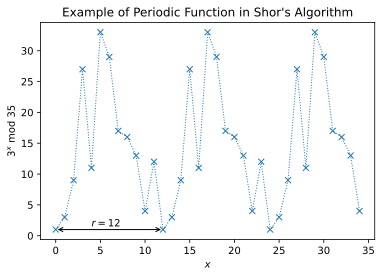

In [2]:
N = 35
a = 3

# Calculate the plotting data
xvals = np.arange(35)
yvals = [np.mod(a**x, N) for x in xvals]

# Use matplotlib to display it nicely
fig, ax = plt.subplots()
ax.plot(xvals, yvals, linewidth=1, linestyle='dotted', marker='x')
ax.set(xlabel='$x$', ylabel='$%i^x$ mod $%i$' % (a, N),
       title="Example of Periodic Function in Shor's Algorithm")
try: # plot r on the graph
    r = yvals[1:].index(1) +1 
    plt.annotate(s='', xy=(0,1), xytext=(r,1), arrowprops=dict(arrowstyle='<->'))
    plt.annotate(s='$r=%i$' % r, xy=(r/3,1.5))
except:
    print('Could not find period, check a < N and have no common factors.')

## The Solution

Shor’s solution was to use QPE on the unitary operator:

$$ U|y\rangle \equiv |ay \bmod N \rangle $$

To see how this is helpful, let’s work out what an eigenstate of U might look like. If we started in the state $|1\rangle$, we can see that each successive application of U will multiply the state of our register by $a \pmod N$, and after $r$ applications we will arrive at the state $|1\rangle$ again. For example with $a = 3$ and $N = 35$:

$$\begin{aligned}
U|1\rangle &= |3\rangle & \\
U^2|1\rangle &= |9\rangle \\
U^3|1\rangle &= |27\rangle \\
& \vdots \\
U^{(r-1)}|1\rangle &= |12\rangle \\
U^r|1\rangle &= |1\rangle 
\end{aligned}$$

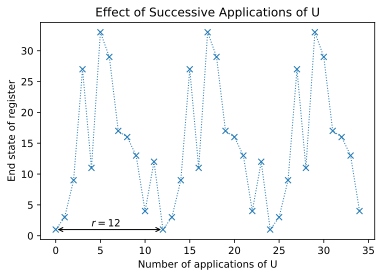

In [3]:
ax.set(xlabel='Number of applications of U', ylabel='End state of register',
       title="Effect of Successive Applications of U")
fig

So an eigenstate of $U$, ($|u_0\rangle$) could be a superposition of the states in this cycle:
$$|u_0\rangle = \tfrac{1}{\sqrt{r}}\sum_{k=0}^{r-1}{|a^k \bmod N\rangle} $$


<details>
    <summary>Click to Expand: Example with $a = 3$ and $N=35$</summary>

$$\begin{aligned}
|u_0\rangle &= \tfrac{1}{\sqrt{12}}(|1\rangle + |3\rangle + |9\rangle \dots + |4\rangle + |12\rangle) \\[10pt]
U|u_0\rangle &= \tfrac{1}{\sqrt{12}}(U|1\rangle + U|3\rangle + U|9\rangle \dots + U|4\rangle + U|12\rangle) \\[10pt]
 &= \tfrac{1}{\sqrt{12}}(|3\rangle + |9\rangle + |27\rangle \dots + |12\rangle + |1\rangle) \\[10pt]
 &= |u_0\rangle
\end{aligned}$$
</details>


This eigenstate has an eigenvalue of 1, which isn’t very interesting. A more interesting eigenstate could be one in which the phase is different for each of these computational basis states. Specifically, let’s look at the case in which the phase of the $k$th state is proportional to $k$:

$$\begin{aligned}
|u_1\rangle &= \tfrac{1}{\sqrt{r}}\sum_{k=0}^{r-1}{e^{-\tfrac{2\pi i k}{r}}|a^k \bmod N\rangle}\\[10pt]
U|u_1\rangle &= e^{\tfrac{2\pi i}{r}}|u_1\rangle 
\end{aligned}
$$

<details>
    <summary>Click to Expand: Example with $a = 3$ and $N=35$</summary>

$$\begin{aligned}
|u_1\rangle &= \tfrac{1}{\sqrt{12}}(|1\rangle + e^{-\tfrac{2\pi i}{12}}|3\rangle + e^{-\tfrac{4\pi i}{12}}|9\rangle \dots + e^{-\tfrac{20\pi i}{12}}|4\rangle + e^{-\tfrac{22\pi i}{12}}|12\rangle) \\[10pt]
U|u_1\rangle &= \tfrac{1}{\sqrt{12}}(|3\rangle + e^{-\tfrac{2\pi i}{12}}|9\rangle + e^{-\tfrac{4\pi i}{12}}|27\rangle \dots + e^{-\tfrac{22\pi i}{12}}|12\rangle + e^{-\tfrac{24\pi i}{12}}|1\rangle) \\[10pt]
U|u_1\rangle &= e^{\tfrac{2\pi i}{12}}|u_1\rangle
\end{aligned}$$

</details>

This is particularly interesting eigenvalue as it contains $r$. This is not the only eigenstate with this behaviour, to generalise this we can multiply an integer, $s$, to this phase difference, which will show up in our eigenvalue:

$$\begin{aligned}
|u_s\rangle &= \tfrac{1}{\sqrt{r}}\sum_{k=0}^{r-1}{e^{-\tfrac{2\pi i s k}{r}}|a^k \bmod N\rangle}\\[10pt]
U|u_s\rangle &= e^{\tfrac{2\pi i s}{r}}|u_s\rangle 
\end{aligned}
$$

We now have a unique eigenstate for each integer value of $s$ where $0 < s < r-1$. Very conveniently, if we sum up all these eigenstates, the different phases cancel out all computational basis states except $|1\rangle$:

$$ \tfrac{1}{\sqrt{r}}\sum_{s=0}^{r-1} |u_s\rangle = |1\rangle$$

<details>
    <summary>Click to Expand: Example with $a = 7$ and $N=15$</summary>

For this, we will look at a smaller example where $a = 7$ and $N=15$. In this case $r=4$:

$$\begin{aligned}
\tfrac{1}{2}(\quad|u_0\rangle &= \tfrac{1}{2}(|1\rangle \hphantom{e^{-\tfrac{2\pi i}{12}}}+ |7\rangle \hphantom{e^{-\tfrac{12\pi i}{12}}} + |4\rangle \hphantom{e^{-\tfrac{12\pi i}{12}}} + |13\rangle)\dots \\[10pt]
+ |u_1\rangle &= \tfrac{1}{2}(|1\rangle + e^{-\tfrac{2\pi i}{4}}|7\rangle + e^{-\tfrac{\hphantom{1}4\pi i}{4}}|4\rangle + e^{-\tfrac{\hphantom{1}6\pi i}{4}}|13\rangle)\dots \\[10pt]
+ |u_2\rangle &= \tfrac{1}{2}(|1\rangle + e^{-\tfrac{4\pi i}{4}}|7\rangle + e^{-\tfrac{\hphantom{1}8\pi i}{4}}|4\rangle + e^{-\tfrac{12\pi i}{4}}|13\rangle)\dots \\[10pt]
+ |u_3\rangle &= \tfrac{1}{2}(|1\rangle + e^{-\tfrac{6\pi i}{4}}|7\rangle + e^{-\tfrac{12\pi i}{4}}|4\rangle + e^{-\tfrac{18\pi i}{4}}|13\rangle)\quad) = |1\rangle \\[10pt]
\end{aligned}$$

</details>

We have seen that the computational basis state $|1\rangle$ is a superposition of these eigenstates, which means if we do QPE on $U$ using the state $|1\rangle$, we will measure a phase:

$$\phi = \frac{s}{r}$$

Where $s$ is a random integer between $0$ and $r-1$. We finally use the continued fractions algorithm on $\phi$ to find $r$. The circuit diagram looks like this:

<img src="images/shor_circuit_1.svg">

We will now demonstrate Shor’s algorithm using Qiskit’s simulators. For this demonstration we will provide the circuits for $U$ without explanation, but in the next section we will discuss how circuits for $U^{2^j}$ can be constructed efficiently.

## Qiskit Implementation

In this example we will solve the period finding problem for $a=7$ and $N=15$. We provide the circuits for $U$ where:

$$U|y\rangle = |ay\bmod 15\rangle $$

without explanation. To create $U^x$, we will simply repeat the circuit $x$ times. In the next section we will discuss a general method for creating these circuit efficiently. The function `c_amod15` returns the controlled-U gate for `a`, repeated `power` times.

In [4]:
def c_amod15(a, power):
    """Controlled multiplication by a mod 15"""
    if a not in [2,7,8,11,13]:
        raise ValueError("'a' must be 2,7,8,11 or 13")
    U = QuantumCircuit(4)        
    for iteration in range(power):
        if a in [2,13]:
            U.swap(0,1)
            U.swap(1,2)
            U.swap(2,3)
        if a in [7,8]:
            U.swap(2,3)
            U.swap(1,2)
            U.swap(0,1)
        if a == 11:
            U.swap(1,3)
            U.swap(0,2)
        if a in [7,11,13]:
            for q in range(4):
                U.x(q)
    U = U.to_gate()
    U.name = "%i^%i mod 15" % (a, power)
    c_U = U.control()
    return c_U

We also provide the circuit for the inverse QFT:

In [5]:
def qft_dagger(n):
    """n-qubit QFTdagger the first n qubits in circ"""
    qc = QuantumCircuit(n)
    # Don't forget the Swaps!
    for qubit in range(n//2):
        qc.swap(qubit, n-qubit-1)
    for j in range(n):
        for m in range(j):
            qc.cu1(-np.pi/float(2**(j-m)), m, j)
        qc.h(j)
    qc.name = "QFT_dag"
    return qc

With these building blocks we can easily construct the circuit for Shor's algorithm:

In [6]:
# Specify variables
n_count = 3 # number of counting qubits
a = 7

# Create QuantumCircuit
qc = QuantumCircuit(4+n_count, n_count)

# Initialise counting qubits
# in state |+>
for q in range(n_count):
    qc.h(q)
    
# And ancilla register in state |1>
qc.x(3+n_count)

# Do controlled-U operations
for q in range(n_count):
    qc.append(c_amod15(a, 2**q), 
             [q] + [i+n_count for i in range(4)])

# Do inverse-QFT
qc.append(qft_dagger(n_count), range(n_count))

# Measure circuit
qc.measure(range(n_count), range(n_count))
qc.draw('text')

┌───┐                                             ┌──────────┐┌─┐      
q_0: ┤ H ├───────■─────────────────────────────────────┤0         ├┤M├──────
     ├───┤       │                                     │          │└╥┘┌─┐   
q_1: ┤ H ├───────┼──────────────■──────────────────────┤1 QFT_dag ├─╫─┤M├───
     ├───┤       │              │                      │          │ ║ └╥┘┌─┐
q_2: ┤ H ├───────┼──────────────┼──────────────■───────┤2         ├─╫──╫─┤M├
     └───┘┌─────┴┼──────┐┌─────┴┼──────┐┌─────┴┼──────┐└──────────┘ ║  ║ └╥┘
q_3: ─────┤0     │      ├┤0     │      ├┤0     │      ├─────────────╫──╫──╫─
          │             ││             ││             │             ║  ║  ║ 
q_4: ─────┤1            ├┤1            ├┤1            ├─────────────╫──╫──╫─
          │  7^1 mod 15 ││  7^2 mod 15 ││  7^4 mod 15 │             ║  ║  ║ 
q_5: ─────┤2            ├┤2            ├┤2            ├─────────────╫──╫──╫─
     ┌───┐│             ││             ││             │             ║  ║  ║ 
q_6: ┤ X ├┤3            ├┤3            ├┤3            ├─────────────╫──╫──╫─
     └───┘└─────────────┘└─────────────┘└─────────────┘             ║  ║  ║ 
c_0: ═══════════════════════════════════════════════════════════════╩══╬══╬═
                                                                       ║  ║ 
c_1: ══════════════════════════════════════════════════════════════════╩══╬═
                                                                          ║ 
c_2: ═════════════════════════════════════════════════════════════════════╩═

Let's see what results we measure:

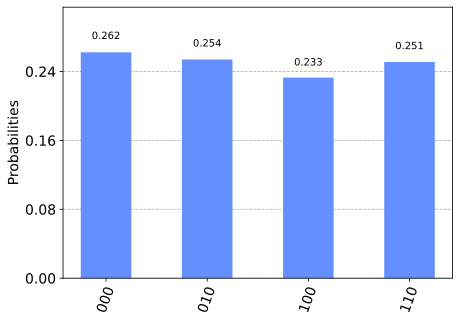

In [7]:
backend = Aer.get_backend('qasm_simulator')
results = execute(qc, backend, shots=2048).result()
counts = results.get_counts()
plot_histogram(counts)

Since we have 3 qubits, these results correspond to measured eigenvalues of:

In [8]:
# Create nice markdown table
from IPython.display import Markdown
# Print table headers
outstr = "| Register Output   |      Phase \t|\n"
outstr += "|:{0}:|:{0}:|\n".format("-"*17)

phases = []
eigenvalues = []
for output in counts:
    decimal = int(output, 2)
    eigenvalue = decimal/(2**n_count)
    eigenvalues.append(eigenvalue)
    outstr += "|`{0}(bin)` = `{1}(dec)`  |  {1}/{2} = {3}\t|\n".format(output, decimal, 2**n_count, eigenvalue)
Markdown(outstr)

| Register Output   |      Phase 	|
|:-----------------:|:-----------------:|
|`100(bin)` = `4(dec)`  |  4/8 = 0.5	|
|`110(bin)` = `6(dec)`  |  6/8 = 0.75	|
|`010(bin)` = `2(dec)`  |  2/8 = 0.25	|
|`000(bin)` = `0(dec)`  |  0/8 = 0.0	|


We can use built-in Python functionality `.as_integer_ratio()` to convert these phases to fractions:

In [9]:
0.75.as_integer_ratio()

(3, 4)

In [10]:
from IPython.display import Markdown
outstr = ""
outstr += "|\tPhase\t|  Fraction\t|\n" # Table headers
outstr += "|:{0}:|:{0}:|\n".format("-"*13)
for eigenvalue in eigenvalues:
    numerator, denominator = eigenvalue.as_integer_ratio()
    outstr += "|   {0}  \t|   {1}/{2} \t|\n".format(eigenvalue, numerator, denominator)
Markdown(outstr)

|	Phase	|  Fraction	|
|:-------------:|:-------------:|
|   0.5  	|   1/2 	|
|   0.75  	|   3/4 	|
|   0.25  	|   1/4 	|
|   0.0  	|   0/1 	|


We can see that two of the measured eigenvalues provided us with the correct result: $r=4$. We can see that Shor’s algorithm has a chance of failing. These bad results are because $s = 0$, or because $s$ and $r$ are not coprime and instead of $r$ we are given a factor of $r$. The easiest solution to this is to simply repeat the experiment until we get a satisfying result for $r$.

### Quick Exercise

- Modify the circuit above for values of $a = 2, 8, 11$ and $13$. What results do you get and why?